In [157]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.cluster.hierarchy as sch
import seaborn as sns
import umap

from collections import defaultdict
from pgmpy.estimators import HillClimbSearch, BicScore
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [2]:
def get_none_colunms(df: pd.DataFrame) -> pd.Series:
    return df.isna().sum().where(lambda x : x > 0).dropna().sort_values(ascending=False)

In [151]:
def print_result(df: pd.DataFrame, lasso: bool = False, target_col: str = 'last_price') -> None:
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    scaler = StandardScaler()
    X_train_st = scaler.fit_transform(X_train)
    X_test_st = scaler.transform(X_test)
    if lasso:
        model = Lasso()
    else:
        model = LinearRegression()
    model.fit(X_train_st, y_train)
    if lasso:
        print(model.coef_)
    y_pred = model.predict(X_test_st)
    
# res = '{:,.2f}'.format(num)
    print(f'RMSE:\t{root_mean_squared_error(y_test, y_pred):_.2f}\nR2:\t{r2_score(y_test, y_pred):.2f}')

In [4]:
df = pd.read_csv('./real_estate_data.csv', sep='\t')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [6]:
max_name_lenght = max(map(lambda x: len(x), df.columns))

In [7]:
for col in df.columns:
    print(col.ljust(max_name_lenght + 1), df[col].nunique(), df[col].dtype, sep='\t')

total_images         	38	int64
last_price           	2978	float64
total_area           	2182	float64
first_day_exposition 	1491	object
rooms                	17	int64
ceiling_height       	183	float64
floors_total         	36	float64
living_area          	1782	float64
floor                	33	int64
is_apartment         	2	object
studio               	2	bool
open_plan            	2	bool
kitchen_area         	971	float64
balcony              	6	float64
locality_name        	364	object
airports_nearest     	8275	float64
cityCenters_nearest  	7642	float64
parks_around3000     	4	float64
parks_nearest        	995	float64
ponds_around3000     	4	float64
ponds_nearest        	1096	float64
days_exposition      	1141	float64


In [8]:
categorical_columns = [col for col in df.columns if df[col].dtype not in ['int64', 'float64']]
numeric_columns = list(set(df.columns) - set(categorical_columns))

In [9]:
categorical_columns

['first_day_exposition',
 'is_apartment',
 'studio',
 'open_plan',
 'locality_name']

In [10]:
df_categorical = df[categorical_columns]
df_numeric = df[numeric_columns]

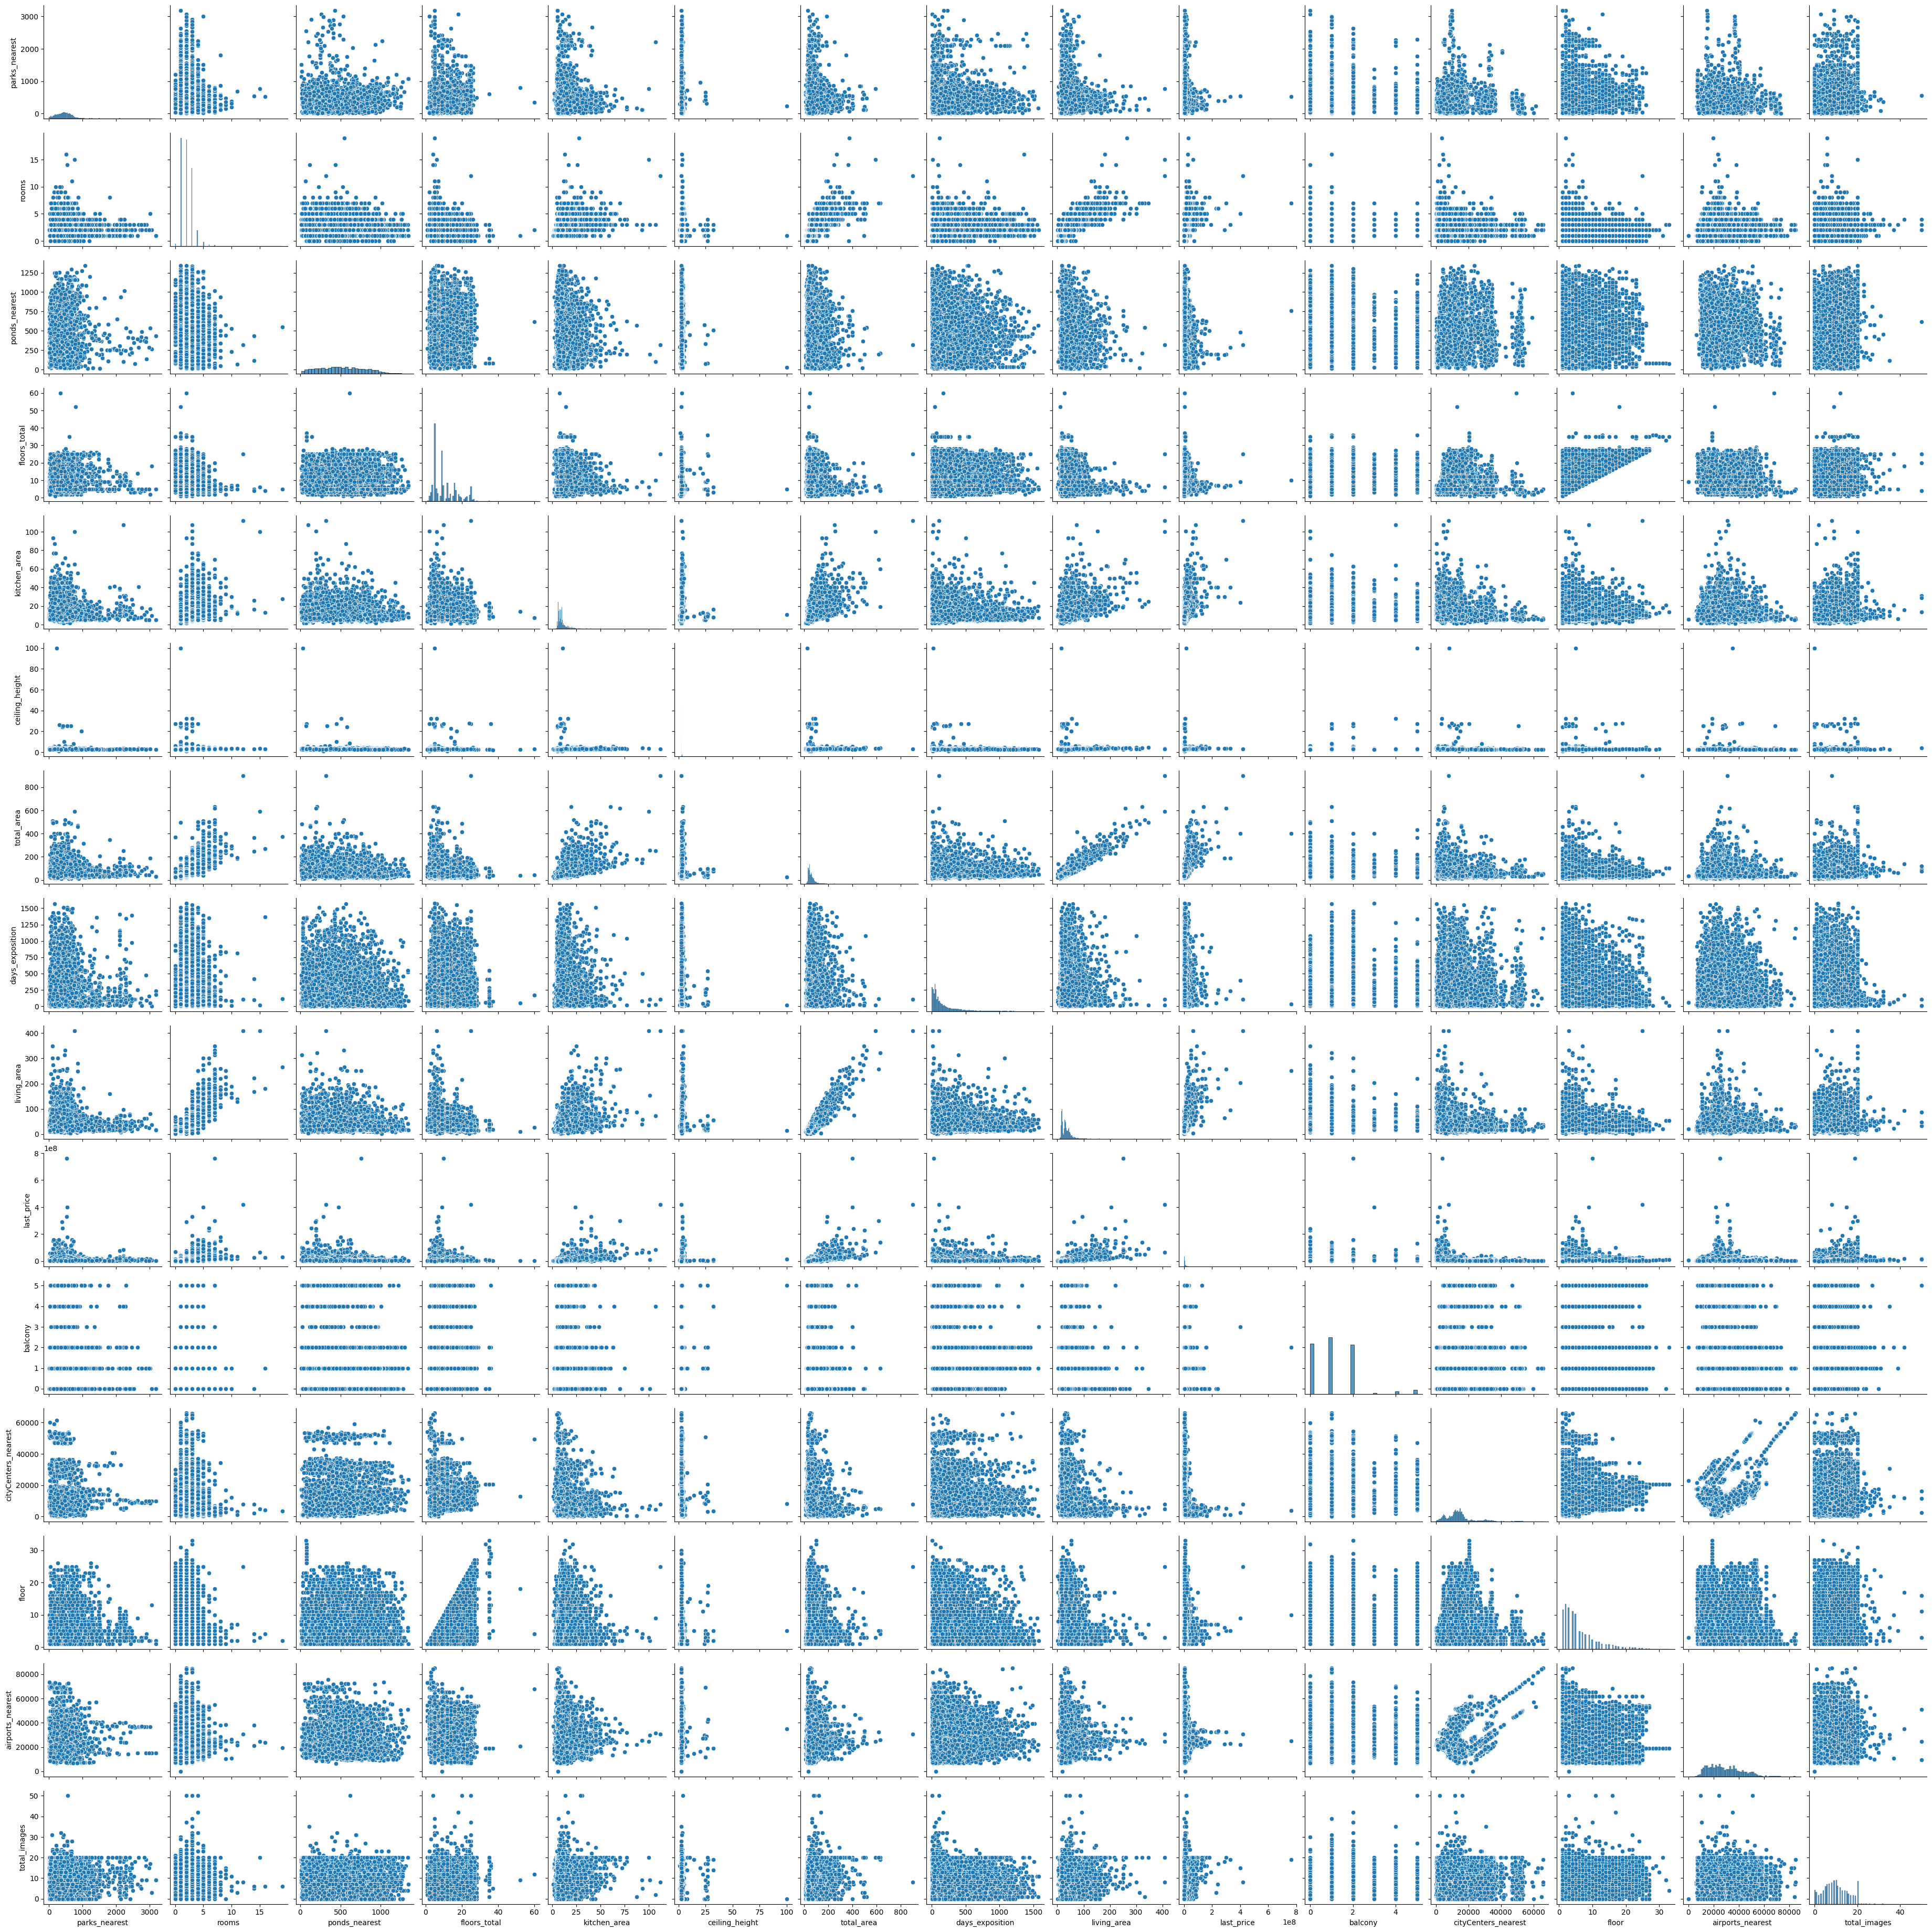

In [11]:
plt.figsize=(15, 20)
sns.pairplot(df_numeric[[col for col in df_numeric.columns if df_numeric[col].nunique() > 5]]);

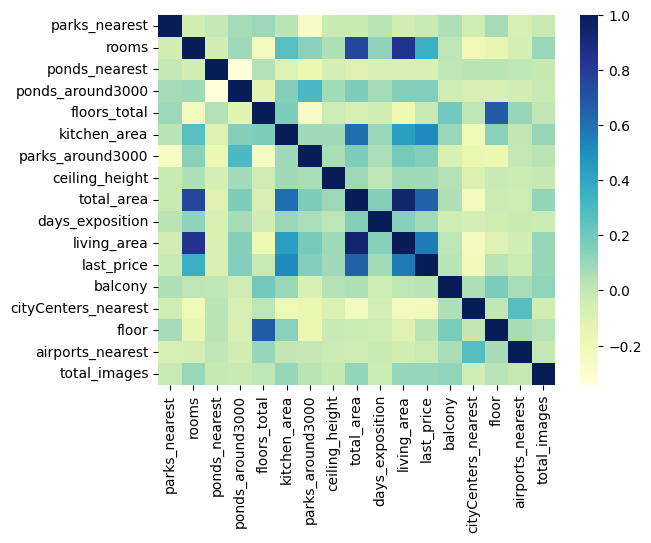

In [12]:
sns.heatmap(df_numeric.corr(),
            cmap="YlGnBu");

In [13]:
CORR_THRESHOLD = 0.5

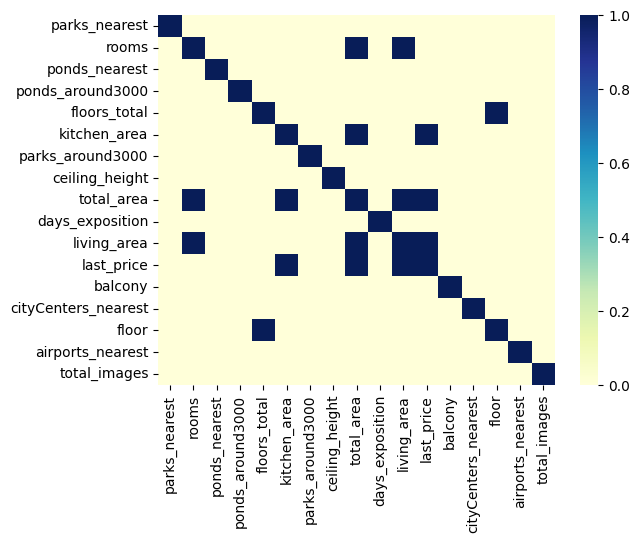

In [14]:
sns.heatmap(df_numeric.corr().abs() > CORR_THRESHOLD,
            cmap="YlGnBu");

In [15]:
strong_corrs = df_numeric.corr().abs()\
                 .stack()\
                 .reset_index()\
                 .rename({0: 'corr'}, axis=1)
strong_corrs = strong_corrs.query(f"corr > {CORR_THRESHOLD}")\
            .query(f"level_0 < level_1")\
            .sort_values(by=['level_0', 'level_1'])\
            .reset_index(drop=True)\
            .round(2)
strong_corrs

level_0       level_1  corr
0         floor  floors_total  0.68
1  kitchen_area    last_price  0.52
2  kitchen_area    total_area  0.61
3    last_price   living_area  0.57
4    last_price    total_area  0.65
5   living_area         rooms  0.85
6   living_area    total_area  0.94
7         rooms    total_area  0.76

In [16]:
adjacency_list = defaultdict(list)

for _, row in strong_corrs.iterrows():
    start = row['level_0']
    end = row['level_1']
    adjacency_list[start].append(end)
    adjacency_list[end].append(start)

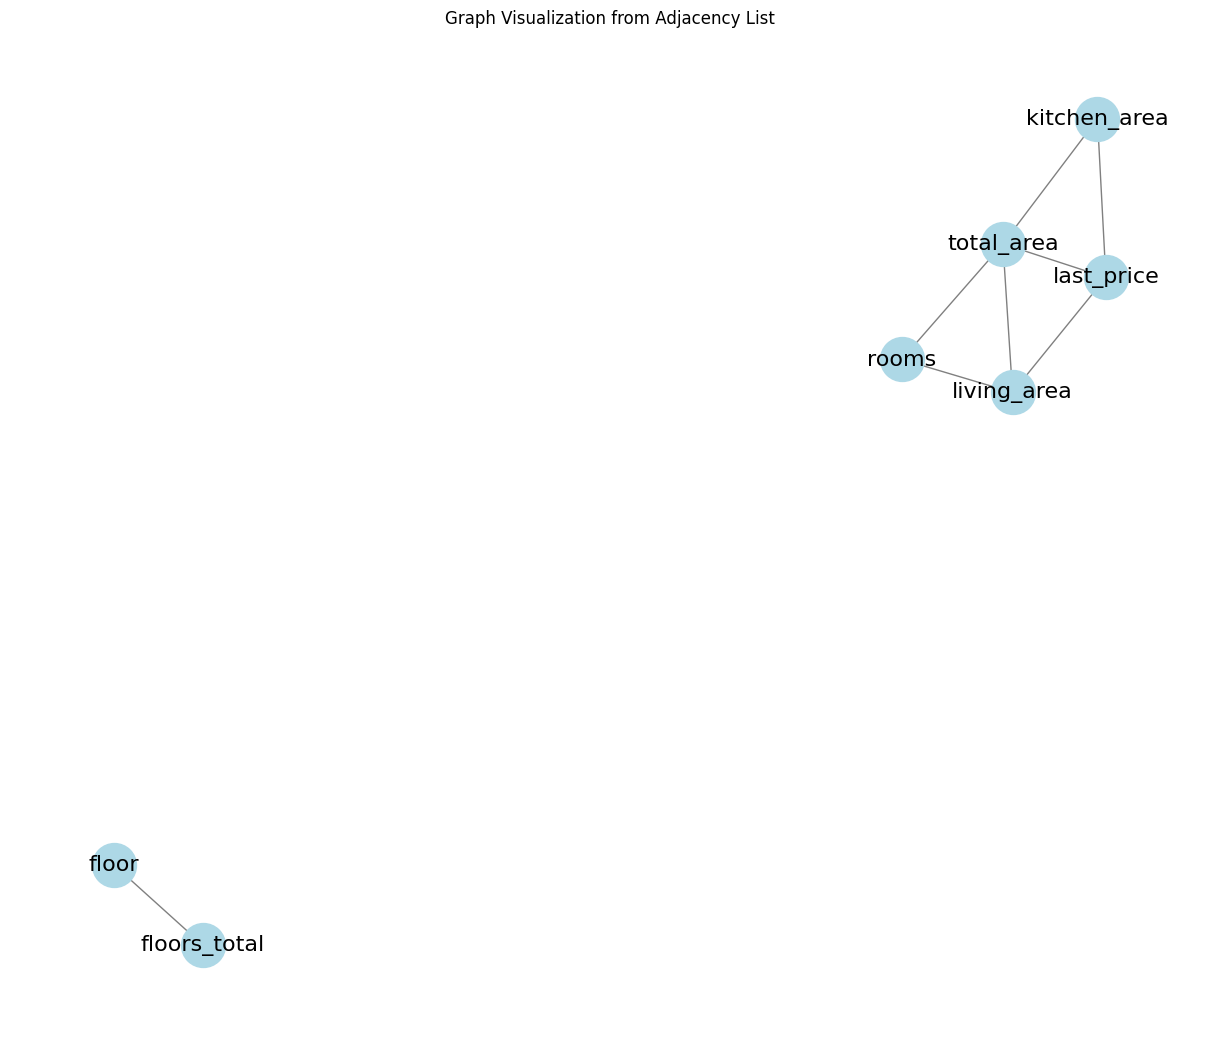

In [17]:
G = nx.Graph()
for node, neighbors in adjacency_list.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)


plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=16, font_color='black', edge_color='gray')

plt.title("Graph Visualization from Adjacency List")
plt.show()

In [18]:
df[['floors_total', 'floor']].isna().sum()

floors_total    86
floor            0
dtype: int64

*floors_total* will be deleted, because it has correlation with another column and has NaN values

In [19]:
df[['kitchen_area', 'last_price', 'total_area', 'living_area', 'rooms']].isna().sum()

kitchen_area    2278
last_price         0
total_area         0
living_area     1903
rooms              0
dtype: int64

*kitchen_area*, *living_area* will be deleted for the same reasons

## 0. Basic Preparation

## 0.1 Work with the object

In [20]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

In [21]:
df['is_apartment'].value_counts()

is_apartment
False    2725
True       50
Name: count, dtype: int64

In [22]:
df['locality_name'].value_counts().keys()

Index(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово',
       'Выборг',
       ...
       'деревня Большое Рейзино', 'деревня Малая Романовка',
       'поселок Дружноселье', 'поселок Пчевжа', 'поселок Володарское',
       'деревня Нижняя', 'коттеджный посёлок Лесное', 'деревня Тихковицы',
       'деревня Борисова Грива', 'посёлок Дзержинского'],
      dtype='object', name='locality_name', length=364)

It is one-dimensional analysis, but it is very good idea to remain only St. Petersburg

In [23]:
df['is_spb'] = df['locality_name'] == 'Санкт-Петербург'

In [24]:
df.drop(['locality_name'], axis=1, inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

There is remain only *is_apartment* as a datatype object. There will be handled later.

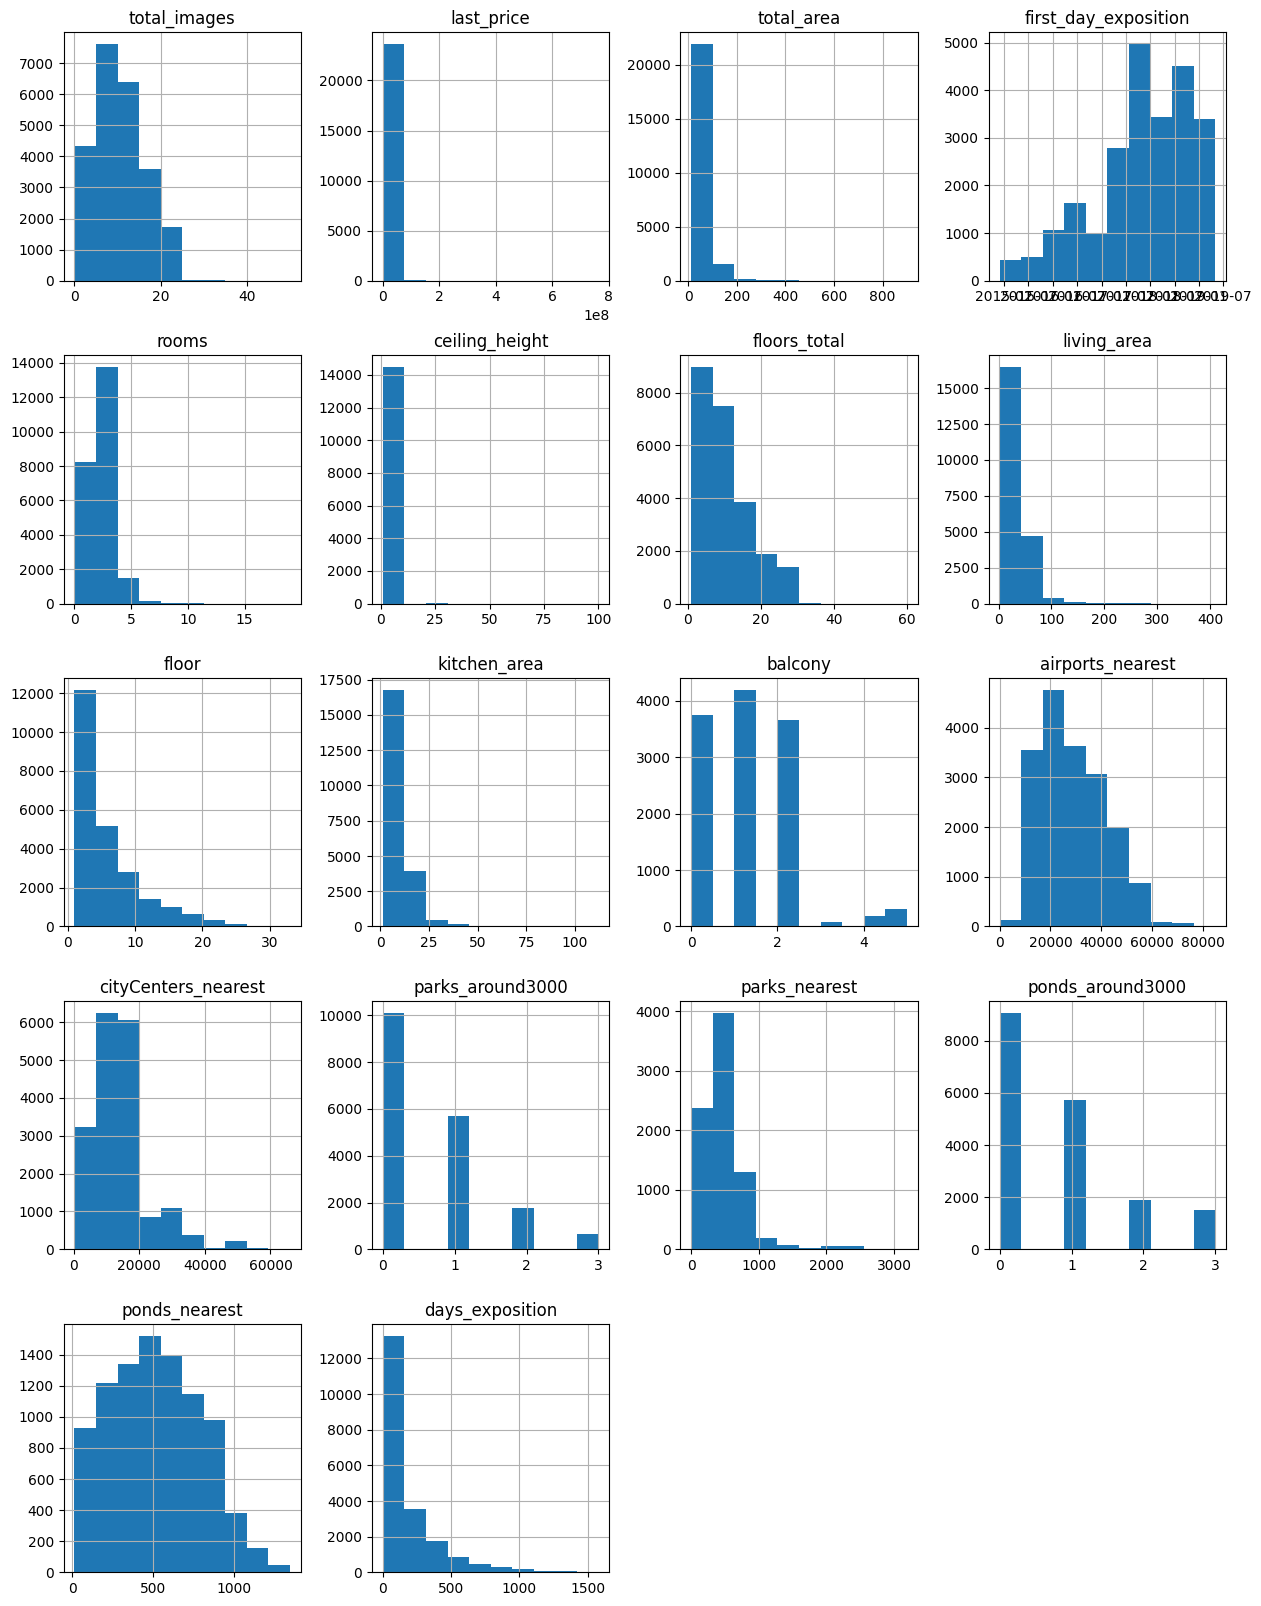

In [26]:
df.hist(figsize=(15, 20));

## 0.2 Work with NULLs

In [27]:
none_info = get_none_colunms(df)
none_info

is_apartment           20924.0
parks_nearest          15620.0
ponds_nearest          14589.0
balcony                11519.0
ceiling_height          9195.0
airports_nearest        5542.0
cityCenters_nearest     5519.0
ponds_around3000        5518.0
parks_around3000        5518.0
days_exposition         3181.0
kitchen_area            2278.0
living_area             1903.0
floors_total              86.0
dtype: float64

### 0.2.1 *is_apartment*

In [28]:
df['is_apartment'].value_counts()

is_apartment
False    2725
True       50
Name: count, dtype: int64

In [29]:
df_is_apartment = df[df['is_apartment'] == True]
df_is_not_apartment = df[df['is_apartment'] == False]

In [30]:
df_is_apartment.describe()

total_images    last_price  total_area first_day_exposition      rooms  \
count       50.0000  5.000000e+01   50.000000                   50  50.000000   
mean        11.1600  1.292420e+07   83.325800  2018-01-31 08:09:36   2.080000   
min          0.0000  2.150000e+06   20.100000  2014-12-09 00:00:00   1.000000   
25%          8.0000  4.815750e+06   47.800000  2017-11-06 00:00:00   1.000000   
50%         11.0000  6.900000e+06   64.000000  2018-07-23 00:00:00   2.000000   
75%         16.0000  1.246768e+07   95.950000  2018-11-01 00:00:00   3.000000   
max         20.0000  8.400000e+07  507.000000  2019-04-26 00:00:00   7.000000   
std          5.9637  1.616967e+07   74.015753                  NaN   1.209486   

       ceiling_height  floors_total  living_area     floor  kitchen_area  \
count       44.000000     50.000000    42.000000  50.00000     35.000000   
mean         6.313864      6.900000    47.979524   4.48000     17.727429   
min          2.500000      2.000000    13.920000   1.00000      5.000000   
25%          2.800000      4.000000    20.422500   2.00000     10.000000   
50%          3.000000      5.000000    33.250000   3.00000     11.700000   
75%          3.200000      7.000000    55.700000   5.00000     20.000000   
max        100.000000     27.000000   301.500000  22.00000     87.200000   
std         15.213780      5.218687    49.462974   3.96536     15.749551   

         balcony  airports_nearest  cityCenters_nearest  parks_around3000  \
count  31.000000         41.000000            43.000000         43.000000   
mean    2.064516      33166.463415         14851.000000          0.953488   
min     1.000000       8426.000000           318.000000          0.000000   
25%     1.000000      24309.000000          5735.000000          0.000000   
50%     2.000000      31006.000000         13261.000000          0.000000   
75%     2.000000      44870.000000         20802.000000          2.000000   
max     5.000000      73391.000000         54490.000000          3.000000   
std     1.314927      12961.095675         11138.598302          1.174197   

       parks_nearest  ponds_around3000  ponds_nearest  days_exposition  
count      19.000000         43.000000      30.000000        38.000000  
mean      255.263158          1.232558     534.200000       258.736842  
min         4.000000          0.000000      22.000000         6.000000  
25%       116.500000          0.000000     322.000000        19.750000  
50%       160.000000          1.000000     569.000000        78.000000  
75%       363.500000          2.500000     792.000000       276.750000  
max       714.000000          3.000000     826.000000      1572.000000  
std       199.620151          1.151339     264.508575       389.759294

In [31]:
df_is_not_apartment.describe()

total_images    last_price   total_area           first_day_exposition  \
count   2725.000000  2.725000e+03  2725.000000                           2725   
mean       9.230092  6.522225e+06    61.123761  2017-02-20 23:52:36.110091520   
min        0.000000  5.500000e+05    13.000000            2014-11-27 00:00:00   
25%        5.000000  3.500000e+06    41.000000            2016-04-13 00:00:00   
50%        9.000000  4.700000e+06    54.000000            2017-02-13 00:00:00   
75%       13.000000  6.800000e+06    72.000000            2017-12-11 00:00:00   
max       21.000000  4.013000e+08   401.000000            2019-05-03 00:00:00   
std        5.485756  1.052674e+07    32.063190                            NaN   

             rooms  ceiling_height  floors_total  living_area        floor  \
count  2725.000000     1818.000000   2725.000000  2613.000000  2725.000000   
mean      2.086606        2.873812     10.737248    35.026973     5.976147   
min       0.000000        2.000000      1.000000    10.000000     1.000000   
25%       1.000000        2.550000      5.000000    19.000000     2.000000   
50%       2.000000        2.700000      9.000000    31.000000     5.000000   
75%       3.000000        2.800000     16.000000    43.000000     8.000000   
max       9.000000       32.000000     35.000000   204.000000    32.000000   
std       1.018471        1.715555      6.542470    19.939367     4.909065   

       kitchen_area      balcony  airports_nearest  cityCenters_nearest  \
count   2550.000000  2267.000000       2103.000000          2104.000000   
mean      10.750020     1.207322      28524.539705         14208.418726   
min        2.890000     0.000000       6914.000000           208.000000   
25%        7.500000     0.000000      18417.000000          9047.000000   
50%        9.800000     1.000000      26293.000000         12945.000000   
75%       12.000000     2.000000      36853.000000         16114.000000   
max       93.200000     5.000000      84665.000000         65764.000000   
std        5.708797     1.056765      12450.314240          8924.336308   

       parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
count       2104.000000     928.000000       2104.000000    1046.000000   
mean           0.614068     508.614224          0.795152     502.630019   
min            0.000000       9.000000          0.000000      16.000000   
25%            0.000000     300.750000          0.000000     276.500000   
50%            0.000000     460.500000          0.000000     485.500000   
75%            1.000000     618.000000          1.000000     710.750000   
max            3.000000    2532.000000          3.000000    1275.000000   
std            0.807897     364.804290          0.975864     273.889273   

       days_exposition  
count      2462.000000  
mean        218.556458  
min           2.000000  
25%          53.000000  
50%         132.000000  
75%         301.750000  
max        1375.000000  
std         235.341230

In [32]:
corr_dict = {col: df['last_price'].corr(df[col], method='spearman') for col in df.columns if abs(df['last_price'].corr(df[col], method='spearman')) > 0.6}

In [33]:
corr_dict

{'last_price': np.float64(1.0),
 'total_area': np.float64(0.7483494842427628),
 'living_area': np.float64(0.6401284327004299)}

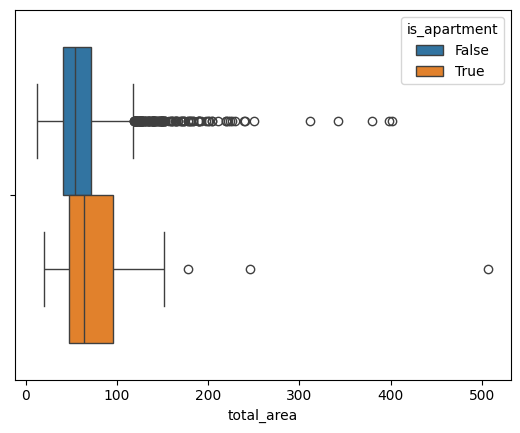

In [34]:
sns.boxplot(data=df, x="total_area", hue="is_apartment");

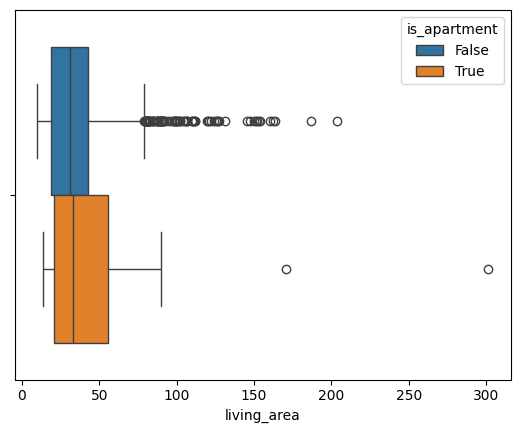

In [35]:
sns.boxplot(data=df, x="living_area", hue="is_apartment");

In [36]:
liv_area_threshold = np.percentile(df_is_apartment['living_area'].dropna(), 95)
liv_area_threshold

np.float64(89.85999999999999)

In [37]:
total_area_threshold = np.percentile(df_is_apartment['total_area'].dropna(), 95)
total_area_threshold

np.float64(166.24499999999992)

Basic idea: Changing NaN to False in the *is_apartment* columns. Beside the living_area is more than 85.8

In [38]:
df['is_apartment'] = df['is_apartment'].fillna(df['living_area'].dropna() > liv_area_threshold)
df['is_apartment'] = df['is_apartment'].fillna(df['total_area'].dropna() > total_area_threshold)

C:\Users\Ilia\AppData\Local\Temp\ipykernel_5724\3167554976.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_apartment'] = df['is_apartment'].fillna(df['total_area'].dropna() > total_area_threshold)


In [39]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	10_329_595.97
R2:	0.52


### 0.2.2 *parks_nearest*

In [40]:
corr_dict = {col: df['parks_nearest'].corr(df[col]) for col in df.columns if abs(df['parks_nearest'].corr(df[col])) > 0.6}
corr_dict

{'parks_nearest': np.float64(1.0)}

In [41]:
df['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Hard to undertand how the best (or just good) way to fill NaN values in the *parks_nearest*

In [42]:
df.drop(['parks_nearest'], axis=1, inplace=True)

In [43]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	7_524_697.43
R2:	0.55


### 0.2.3 *ponds_nearest*

In [44]:
corr_dict = {col: df['ponds_nearest'].corr(df[col]) for col in df.columns if abs(df['ponds_nearest'].corr(df[col])) > 0.6}
corr_dict

{'ponds_nearest': np.float64(1.0)}

Hard to undertand how the best (or just good) way to fill NaN values in the *ponds_nearest*

In [45]:
df.drop(['ponds_nearest'], axis=1, inplace=True)

In [46]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	5_565_807.48
R2:	0.59


### 0.2.4 *floors_total*

In [47]:
df.drop(['floors_total'], axis=1, inplace=True)

In [48]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	5_555_934.11
R2:	0.59


### 0.2.5 *kitchen area*, *living area*

In [49]:
df.drop(['kitchen_area', 'living_area'], axis=1, inplace=True)

In [50]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	5_423_024.75
R2:	0.60


### 0.2.6 *balcony*

In [51]:
df['balcony'].value_counts()

balcony
1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: count, dtype: int64

In [52]:
df_has_not_balcony = df[df['balcony'] <= 2]
df_has_balcony = df[df['balcony'] > 2]

In [53]:
curr_num_col = list(set(numeric_columns) - set(['floors_total', 'parks_nearest', 'living_area', 'kitchen_area', 'ponds_nearest']))

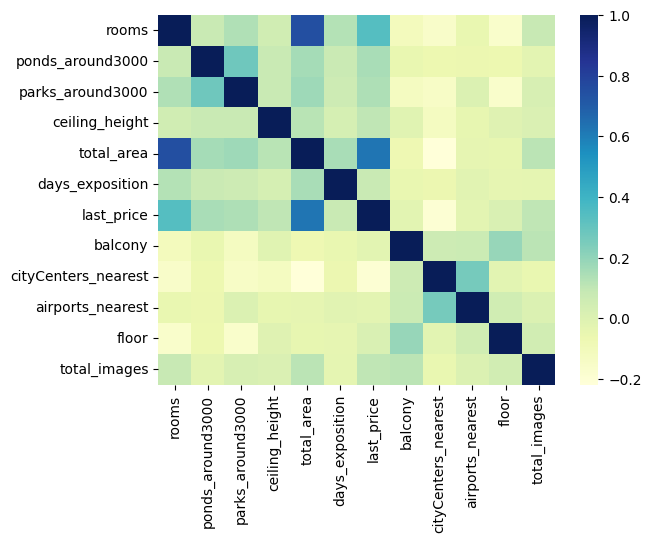

In [54]:
sns.heatmap(df_has_not_balcony[curr_num_col].corr(),
            cmap="YlGnBu");

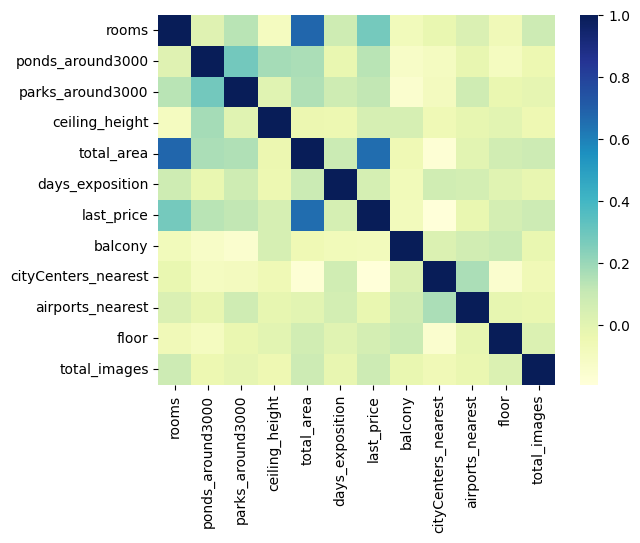

In [55]:
sns.heatmap(df_has_balcony[curr_num_col].corr(),
            cmap="YlGnBu");

Hard to undertand how the best (or just good) way to fill NaN values in the *balcony*

In [56]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'] = df['balcony'].astype(int)

In [57]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	7_185_384.26
R2:	0.62


### 0.2.7 *ceiling_height*

In [58]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [59]:
np.percentile(df['ceiling_height'].dropna(), 90)

np.float64(3.06)

In [60]:
df['ceiling_height'].dropna().sort_values(ascending=True)

22590      1.00
5712       1.20
16934      1.75
5850       2.00
16446      2.00
          ...  
20478     27.00
21377     27.50
3148      32.00
22336     32.00
22869    100.00
Name: ceiling_height, Length: 14504, dtype: float64

There is outlier: it will be deleted

In [61]:
# index_to_del = df[df['ceiling_height'] == 100].index
# df.drop(index_to_del, axis=0, inplace=True)

In [62]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [63]:
corr_dict = {col: df['ceiling_height'].corr(df[col]) for col in df.columns if abs(df['ceiling_height'].corr(df[col])) > 0.4}
corr_dict

{'ceiling_height': np.float64(1.0)}

In [64]:
df.drop(['ceiling_height'], axis=1, inplace=True)

In [65]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	6_647_782.20
R2:	0.61


In [66]:
get_none_colunms(df)

airports_nearest       5542.0
cityCenters_nearest    5519.0
parks_around3000       5518.0
ponds_around3000       5518.0
days_exposition        3181.0
dtype: float64

### 0.2.8 *airports_nearest*

<Axes: >

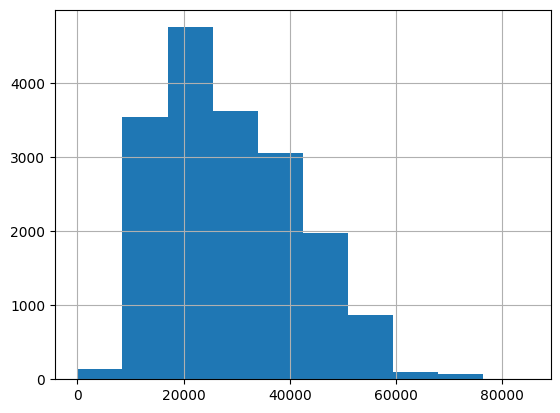

In [67]:
df['airports_nearest'].hist()

In [68]:
df['airports_nearest'].corr(df['last_price'])

np.float64(-0.026238516833888743)

In [69]:
corr_dict = {col: df['airports_nearest'].corr(df[col]) for col in df.columns if abs(df['airports_nearest'].corr(df[col])) > 0.4}
corr_dict

{'airports_nearest': np.float64(1.0)}

In [70]:
df.drop(columns=['airports_nearest'], axis=1, inplace=True)

In [71]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	6_643_053.27
R2:	0.61


In [72]:
get_none_colunms(df)

cityCenters_nearest    5519.0
parks_around3000       5518.0
ponds_around3000       5518.0
days_exposition        3181.0
dtype: float64

### 0.2.9 *cityCenters_nearest*

In [73]:
df['cityCenters_nearest'].corr(df['last_price'])

np.float64(-0.20674734874298373)

In [74]:
corr_dict = {col: df['cityCenters_nearest'].corr(df[col]) for col in df.columns if abs(df['cityCenters_nearest'].corr(df[col])) > 0.4}
corr_dict

{'cityCenters_nearest': np.float64(1.0),
 'is_spb': np.float64(-0.7500380057674844)}

There is strong correlation between *cityCenters_nearest* and *is_spb*. The *cityCenters_nearest* will be deleted because has NaN

In [75]:
df.drop(columns=['cityCenters_nearest'], axis=1, inplace=True)

In [76]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	6_642_419.95
R2:	0.61


### 0.2.9 *parks_around3000*

In [77]:
df['parks_around3000'].value_counts()

parks_around3000
0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: count, dtype: int64

In [78]:
df['parks_around3000'].corr(df['last_price'])

np.float64(0.15105833966077947)

In [79]:
corr_dict = {col: df['parks_around3000'].corr(df[col]) for col in df.columns if abs(df['parks_around3000'].corr(df[col])) > 0.4}
corr_dict

{'parks_around3000': np.float64(1.0)}

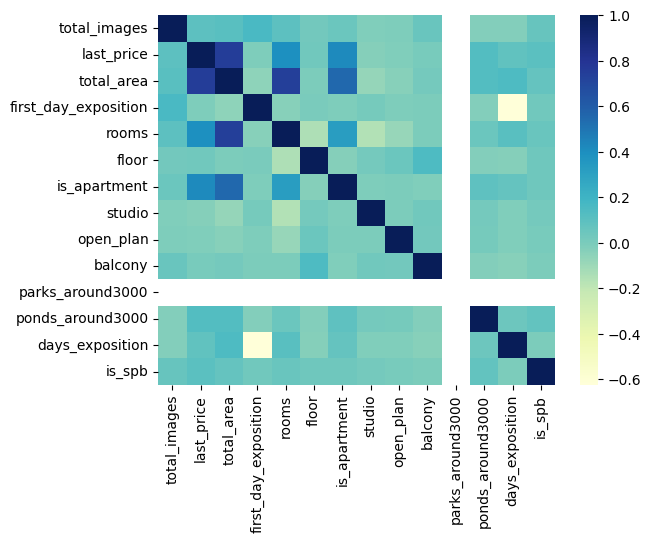

In [80]:
sns.heatmap(df[df['parks_around3000'] == 0].corr(),
            cmap="YlGnBu");

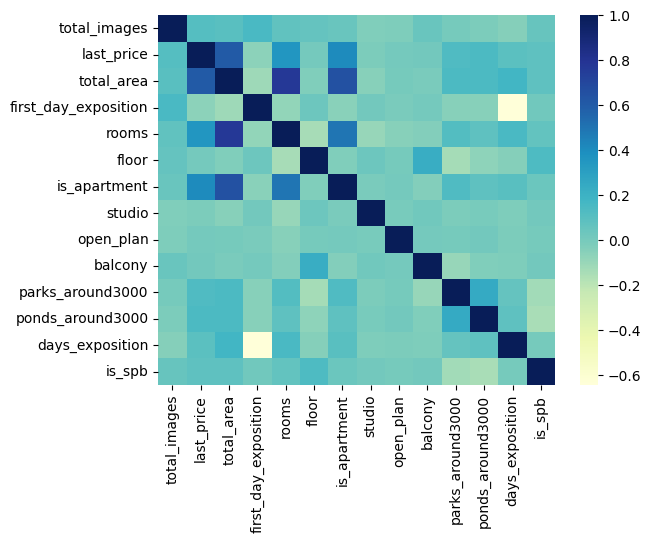

In [81]:
sns.heatmap(df[df['parks_around3000'] > 0].corr(),
            cmap="YlGnBu");

In [82]:
df.drop(columns=['parks_around3000'], axis=1, inplace=True)

In [83]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	6_650_696.78
R2:	0.61


In [84]:
get_none_colunms(df)

ponds_around3000    5518.0
days_exposition     3181.0
dtype: float64

### 0.2.10 *ponds_around3000*

In [85]:
df['ponds_around3000'].value_counts()

ponds_around3000
0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: count, dtype: int64

In [86]:
df['ponds_around3000'].corr(df['last_price'])

np.float64(0.1599956655508371)

In [87]:
corr_dict = {col: df['ponds_around3000'].corr(df[col]) for col in df.columns if abs(df['ponds_around3000'].corr(df[col])) > 0.4}
corr_dict

{'ponds_around3000': np.float64(1.0)}

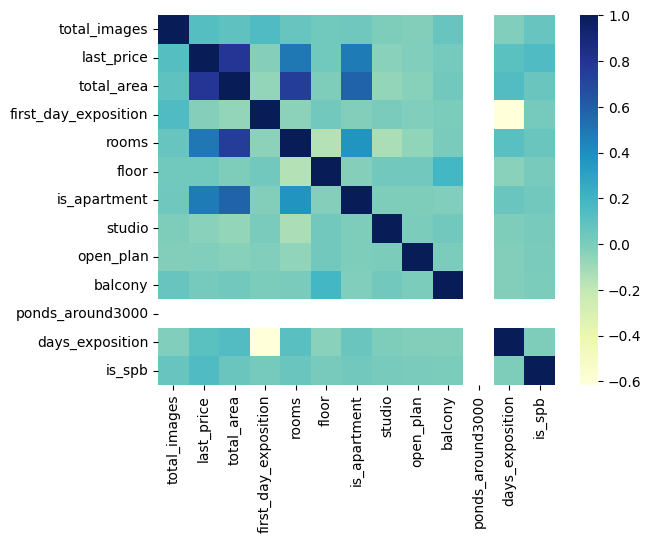

In [88]:
sns.heatmap(df[df['ponds_around3000'] == 0].corr(),
            cmap="YlGnBu");

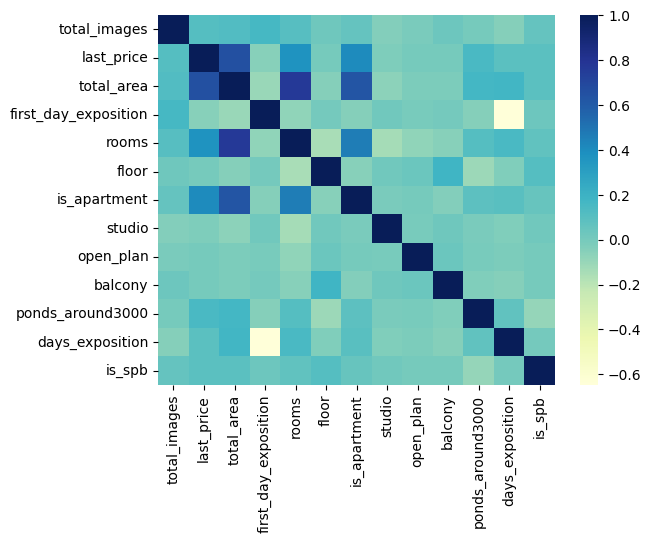

In [89]:
sns.heatmap(df[df['ponds_around3000'] > 0].corr(),
            cmap="YlGnBu");

In [90]:
df.drop(columns=['ponds_around3000'], axis=1, inplace=True)

In [91]:
print_result(df.drop(columns=['first_day_exposition']).dropna())

RMSE:	5_960_128.36
R2:	0.62


In [92]:
get_none_colunms(df)

days_exposition    3181.0
dtype: float64

### 0.2.11 *days_exposition*

<Axes: >

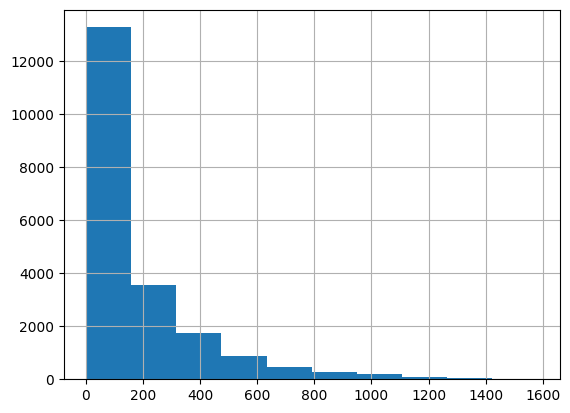

In [93]:
df['days_exposition'].hist()

In [94]:
df['days_exposition'].corr(df['last_price'])

np.float64(0.08114593098611303)

In [95]:
corr_dict = {col: df['days_exposition'].corr(df[col]) for col in df.columns if abs(df['days_exposition'].corr(df[col])) > 0.4}
corr_dict

{'first_day_exposition': np.float64(-0.6294943428768235),
 'days_exposition': np.float64(1.0)}

In [96]:
corr_dict = {col: df['days_exposition'].corr(df[col]) for col in df.columns if abs(df['days_exposition'].corr(df[col])) > 0.4}
corr_dict

{'first_day_exposition': np.float64(-0.6294943428768235),
 'days_exposition': np.float64(1.0)}

<Axes: >

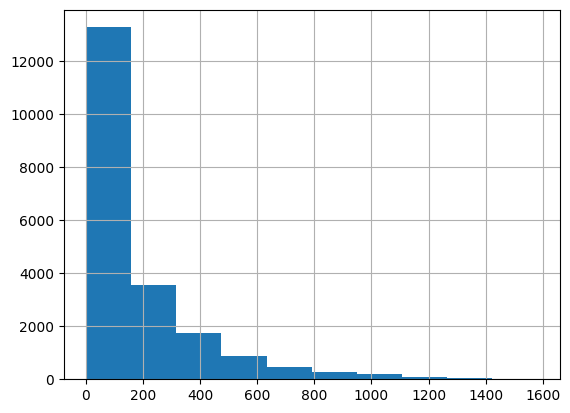

In [97]:
df['days_exposition'].hist()

In [98]:
df.drop(columns=['first_day_exposition'], axis=1, inplace=True)

In [99]:
corr_dict = {col: df['days_exposition'].corr(df[col]) for col in df.columns if abs(df['days_exposition'].corr(df[col])) > 0.4}
corr_dict

{'days_exposition': np.float64(1.0)}

In [100]:
df['days_exposition'] = np.log(df['days_exposition'])

In [101]:
df = df[df['days_exposition'].notna()]

In [102]:
df = df.reset_index(drop=True)

In [103]:
# df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())

In [104]:
print_result(df.dropna())

RMSE:	5_960_150.89
R2:	0.62


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20518 entries, 0 to 20517
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_images     20518 non-null  int64  
 1   last_price       20518 non-null  float64
 2   total_area       20518 non-null  float64
 3   rooms            20518 non-null  int64  
 4   floor            20518 non-null  int64  
 5   is_apartment     20518 non-null  bool   
 6   studio           20518 non-null  bool   
 7   open_plan        20518 non-null  bool   
 8   balcony          20518 non-null  int64  
 9   days_exposition  20518 non-null  float64
 10  is_spb           20518 non-null  bool   
dtypes: bool(4), float64(3), int64(4)
memory usage: 1.2 MB


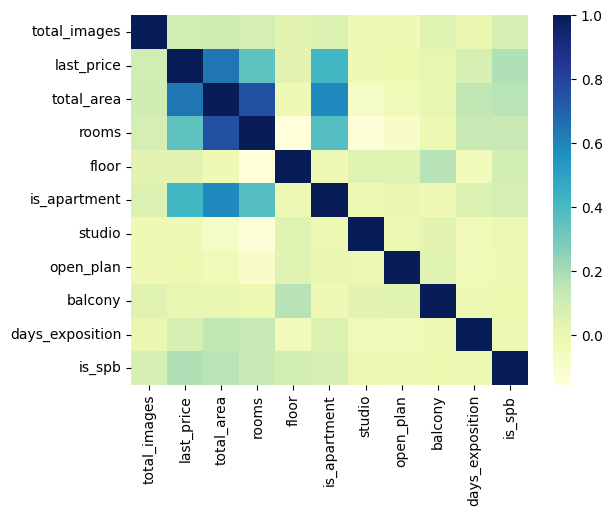

In [106]:
sns.heatmap(df.corr(),
            cmap="YlGnBu");

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20518 entries, 0 to 20517
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_images     20518 non-null  int64  
 1   last_price       20518 non-null  float64
 2   total_area       20518 non-null  float64
 3   rooms            20518 non-null  int64  
 4   floor            20518 non-null  int64  
 5   is_apartment     20518 non-null  bool   
 6   studio           20518 non-null  bool   
 7   open_plan        20518 non-null  bool   
 8   balcony          20518 non-null  int64  
 9   days_exposition  20518 non-null  float64
 10  is_spb           20518 non-null  bool   
dtypes: bool(4), float64(3), int64(4)
memory usage: 1.2 MB


In [108]:
numeric_columns = ['last_price', 'total_area', 'rooms', 'floor', 'days_exposition']
categorical_columns = ['is_apartment', 'studio', 'open_plan', 'is_spb']

In [109]:
df_numeric = df[numeric_columns]

In [110]:
X_numeric = df_numeric.drop(['last_price'], axis=1)
while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_numeric.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                       for i in range(len(X_numeric.columns))]
    ind_max = vif_data["VIF"].idxmax()
    max_vif = vif_data.iloc[ind_max]["VIF"]
    feature = vif_data.iloc[ind_max]["feature"]
    if max_vif < 10:
        print(f'Finish! We have {vif_data.shape[0]} columns')
        break
    else:
        X_numeric = X_numeric.drop([feature], axis=1)

Finish! We have 3 columns


In [111]:
new_numeric_columns = vif_data.feature.to_list()
total_columns = new_numeric_columns + ['last_price']
total_columns = new_numeric_columns + categorical_columns + ['last_price']
new_df = df[total_columns]
print_result(new_df, lasso=False)

RMSE:	6_300_573.29
R2:	0.58


In [112]:
df

total_images  last_price  total_area  rooms  floor  is_apartment  \
0                 7   3350000.0       40.40      1      1         False   
1                10   5196000.0       56.00      2      4         False   
2                 0  64900000.0      159.00      3      9         False   
3                 2  10000000.0      100.00      2     13         False   
4                10   2890000.0       30.40      1      5         False   
...             ...         ...         ...    ...    ...           ...   
20513            11   9470000.0       72.90      2      7         False   
20514             2   1350000.0       30.00      1      4         False   
20515             9   4600000.0       62.40      3      8         False   
20516            14   3100000.0       59.00      3      4         False   
20517            13  11475000.0       76.75      2     12         False   

       studio  open_plan  balcony  days_exposition  is_spb  
0       False      False        2         4.394449   False  
1       False      False        0         6.324359    True  
2       False      False        0         6.049733    True  
3       False      False        0         4.795791    True  
4       False      False        0         4.007333   False  
...       ...        ...      ...              ...     ...  
20513   False      False        1         6.251904    True  
20514   False      False        0         6.023448   False  
20515   False      False        0         5.476464   False  
20516   False      False        0         3.806662   False  
20517   False      False        2         6.400257    True  

[20518 rows x 11 columns]

### PCA

In [113]:
features = df.drop('last_price', axis=1).columns

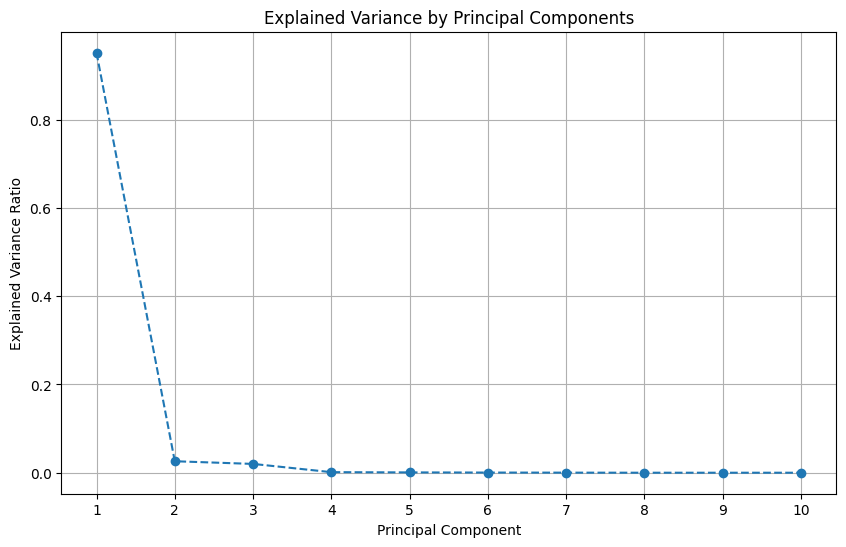

In [114]:
pca = PCA()
pca.fit(df[features])

# Step 4: Get the explained variance ratios
explained_variance = pca.explained_variance_ratio_

# Step 5: Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Step 6: Select the number of components to keep (95% variance)
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Step 7: Fit PCA with the selected number of components and transform data
# pca_n = PCA(n_components=n_components)
# reduced_data = pca_n.fit_transform(df[features])

# # Output the shape of the reduced data
# print("\nReduced Data Shape:")
# print(reduced_data.shape)

# # Output explained variance for the selected components
# print("\nExplained Variance Ratios for Selected Components:")
# print(pca.explained_variance_ratio_)

In [115]:
reduced_data = pca.fit_transform(df[features])

In [116]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}


In [117]:
fig = px.scatter_matrix(
    reduced_data,
    labels=labels,
    dimensions=range(len(features)),
)
fig.update_traces(diagonal_visible=False)
fig.write_html("1.html")

In [118]:
X = reduced_data[:, :9]
y = df['last_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Fit the linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = linear_regressor.predict(X_test)

# Step 8: Evaluate the model
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

7298517.532488839 0.4567709190910102


# DOES NOT WORK

# t-SNE

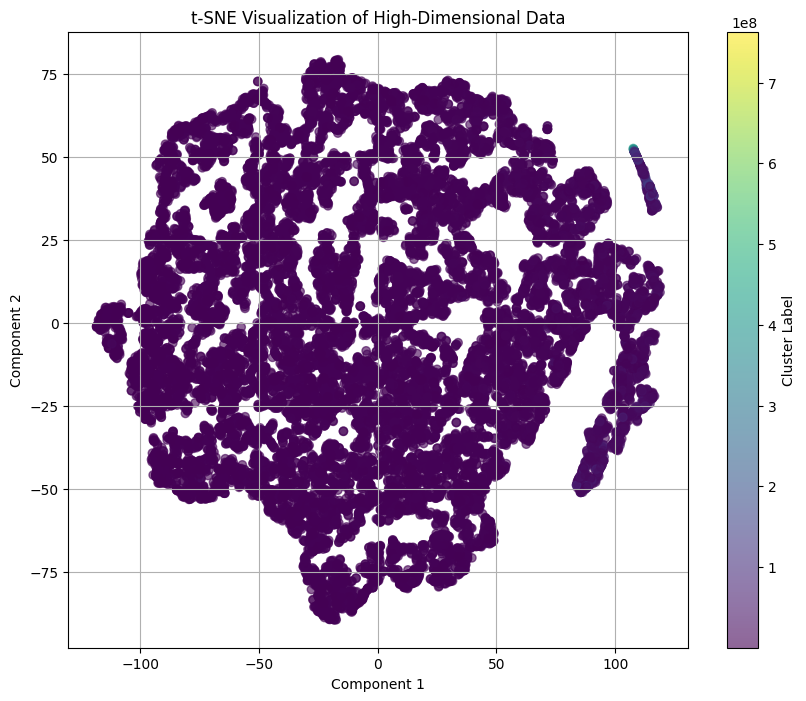

In [119]:
X = df.drop(['last_price'], axis=1)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Step 4: Create a DataFrame for visualization
df_tsne = pd.DataFrame(data=X_tsne, columns=['Component_1', 'Component_2'])
df_tsne['last_price'] = df['last_price']

# Step 5: Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['Component_1'], df_tsne['Component_2'], c=df_tsne['last_price'], cmap='viridis', alpha=0.6)
plt.title("t-SNE Visualization of High-Dimensional Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

In [120]:
print_result(df_tsne)

RMSE:	8_917_592.89
R2:	0.15


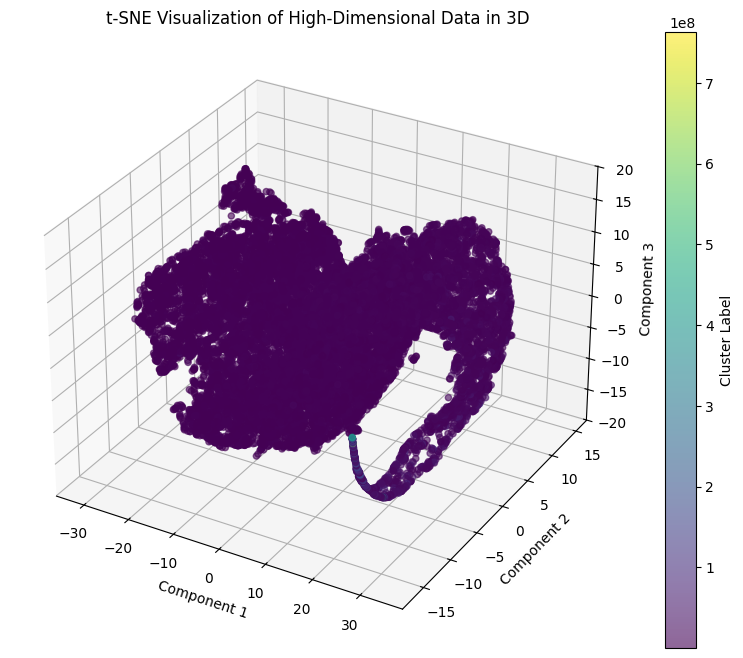

In [121]:
X = df.drop(['last_price'], axis=1)
# Step 3: Apply t-SNE
tsne = TSNE(n_components=3, random_state=42)  # We want 3 components for 3D visualization
X_tsne = tsne.fit_transform(X)

# Step 4: Create a DataFrame for visualization
df_tsne = pd.DataFrame(data=X_tsne, columns=['Component_1', 'Component_2', 'Component_3'])
df_tsne['last_price'] = df['last_price']

# Step 5: Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_tsne['Component_1'], df_tsne['Component_2'], df_tsne['Component_3'], 
                     c=df_tsne['last_price'], cmap='viridis', alpha=0.6)

# Adding titles and labels
ax.set_title("t-SNE Visualization of High-Dimensional Data in 3D")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

# Adding a color bar for reference
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster Label')

plt.show()

In [122]:
print_result(df_tsne)

RMSE:	8_976_411.14
R2:	0.14


C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



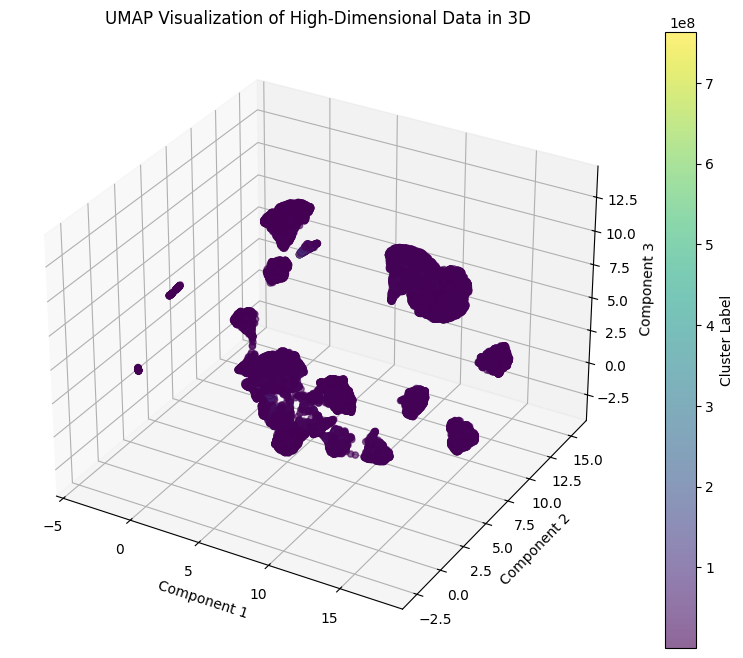

In [129]:
umap_model = umap.UMAP(n_components=3, random_state=42)  # We want 3 components for 3D visualization
X_umap = umap_model.fit_transform(StandardScaler().fit_transform(X))

# Step 4: Create a DataFrame for visualization
df_umap = pd.DataFrame(data=X_umap, columns=['Component_1', 'Component_2', 'Component_3'])
df_umap['last_price'] = df['last_price']

# Step 5: Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_umap['Component_1'], df_umap['Component_2'], df_umap['Component_3'], 
                     c=df_umap['last_price'], cmap='viridis', alpha=0.6)

# Adding titles and labels
ax.set_title("UMAP Visualization of High-Dimensional Data in 3D")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

# Adding a color bar for reference
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster Label')

plt.show()

In [130]:
print_result(df_umap)

RMSE:	9_649_492.91
R2:	0.01


C:\Users\Ilia\ITMO_algorithms\ITMO_mmsa\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



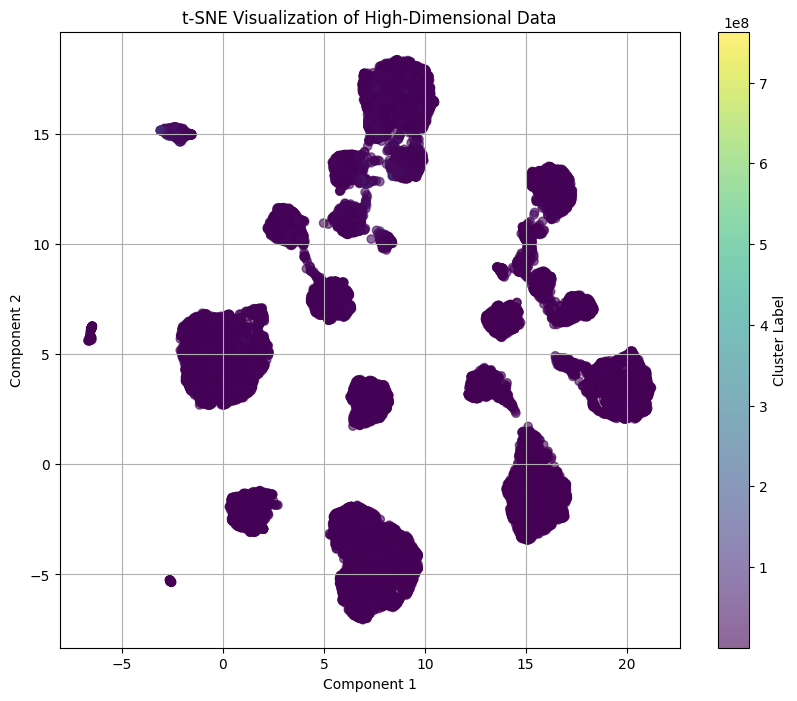

In [127]:
umap_model = umap.UMAP(n_components=2, random_state=42)  # We want 3 components for 3D visualization
X_umap = umap_model.fit_transform(StandardScaler().fit_transform(X))

# Step 4: Create a DataFrame for visualization
df_umap = pd.DataFrame(data=X_umap, columns=['Component_1', 'Component_2',])
df_umap['last_price'] = df['last_price']

# Step 5: Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_umap['Component_1'], df_umap['Component_2'],
                     c=df_umap['last_price'], cmap='viridis', alpha=0.6)

# Adding titles and labels
plt.title("t-SNE Visualization of High-Dimensional Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

In [131]:
print_result(df_umap)

RMSE:	9_649_492.91
R2:	0.01


# KMeans

In [138]:
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    X = df.drop(['last_price'], axis=1)
    df_kmeans = df.copy()
    df_kmeans['KMeans_Cluster'] = kmeans.fit_predict(X)
    print(f'{i}:', end='')
    print(df_kmeans['KMeans_Cluster'].corr(df_kmeans['last_price']))

2:0.4261718795071486
3:0.42702713833152
4:0.1585815924478021
5:-0.11588654326865855
6:-0.07530039074641946
7:-0.2261627094911329
8:-0.03471880743481421
9:0.008860033500246913


In [141]:
kmeans = KMeans(n_clusters=2, random_state=42)
X = df.drop(['last_price'], axis=1)
df_kmeans = df.copy()
df_kmeans['KMeans_Cluster'] = kmeans.fit_predict(X)
print(df_kmeans['KMeans_Cluster'].corr(df_kmeans['last_price']))

0.4261718795071486


In [148]:
df_kmeans['log_last_price'] = np.log(df_kmeans['last_price'])

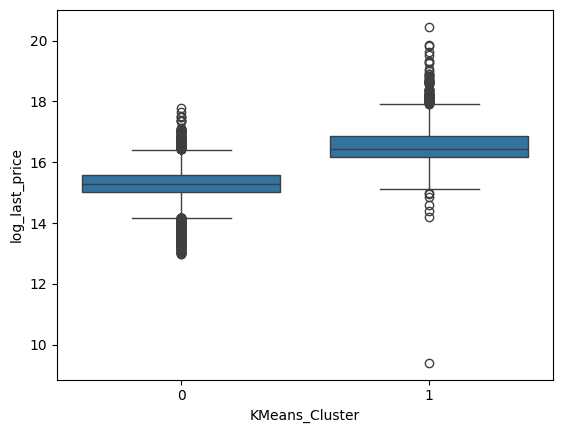

In [149]:
sns.boxplot(data=df_kmeans, y="log_last_price", x="KMeans_Cluster");

In [150]:
print_result(df_kmeans)

RMSE:	5_853_647.14
R2:	0.63


In [153]:
print_result(df_kmeans.drop(['log_last_price'], axis=1))

RMSE:	5_900_023.43
R2:	0.63


In [155]:
print_result(df_kmeans.drop(['last_price'], axis=1), target_col='log_last_price')

RMSE:	0.35
R2:	0.69


# Bayes

In [158]:
hc = HillClimbSearch(df)
best_model = hc.estimate(scoring_method=BicScore(df))

# Output the learned structure
print("Learned Bayesian Network Structure:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Bayesian Network Structure:
[('rooms', 'is_apartment'), ('rooms', 'studio'), ('rooms', 'open_plan'), ('floor', 'is_spb'), ('studio', 'open_plan'), ('studio', 'balcony'), ('is_spb', 'rooms')]


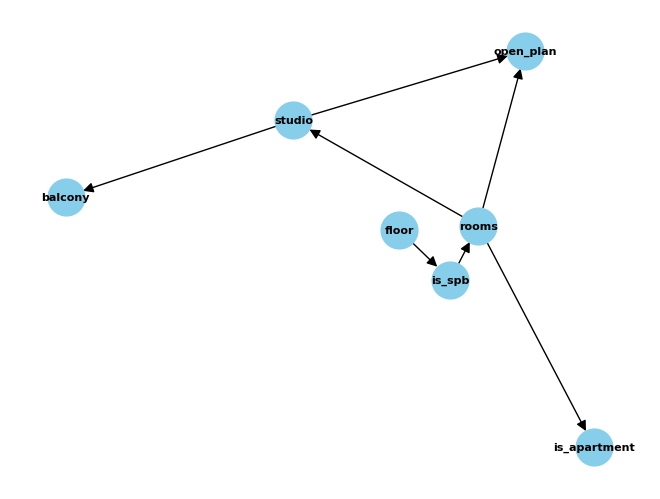

In [164]:
edges = best_model.edges()
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8, arrowsize=15)
plt.show()

In [186]:
df_kmeans.head()

total_images  last_price  total_area  rooms  floor  is_apartment  studio  \
0             7   3350000.0        40.4      1      1         False   False   
1            10   5196000.0        56.0      2      4         False   False   
2             0  64900000.0       159.0      3      9         False   False   
3             2  10000000.0       100.0      2     13         False   False   
4            10   2890000.0        30.4      1      5         False   False   

   open_plan  balcony  days_exposition  is_spb  KMeans_Cluster  log_last_price  
0      False        2         4.394449   False               0       15.024471  
1      False        0         6.324359    True               0       15.463400  
2      False        0         6.049733    True               1       17.988358  
3      False        0         4.795791    True               1       16.118096  
4      False        0         4.007333   False               0       14.876767

In [206]:
print_result(df_kmeans.drop(['open_plan', 'rooms', 'last_price'], axis=1), target_col='log_last_price')

RMSE:	0.35
R2:	0.70


# Fitting initial data

In [124]:
initial = pd.read_csv('./real_estate_data.csv', sep='\t')
initial = initial.drop(columns=[
    'first_day_exposition', 'ceiling_height', 'is_apartment', 'balcony', 'locality_name', 'parks_nearest', 'ponds_nearest'
])
initial = initial.dropna()
print_result(initial)

RMSE:	6_883_335.81
R2:	0.60
